In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

In [2]:
cv2.__version__

'4.5.3'

In [6]:
cv2.cuda.getCudaEnabledDeviceCount()

0

In [7]:
device = "gpu" # please change it to "gpu" if the model needs to be run on cuda.

protoFile = "pose_deploy_linevec.prototxt"
weightsFile = "pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]

net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

if device == "cpu":
    net.setPreferableBackend(cv2.dnn.DNN_TARGET_CPU)
    print("Using CPU device")
elif device == "gpu":
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
    print("Using GPU device")


Using GPU device


In [8]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints

# Find valid connections between the different joints of a all persons present
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))
    
    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [177]:
# t = time.time()
t0 = cv2.getTickCount()
image1 = cv2.imread("C:/Users/BVer/are_you_ok/img/pose8.jpg")
# image1 = cv2.imread('C:/Users/BVer/are_you_o/img/5579.jpg')
frameWidth = image1.shape[1]
frameHeight = image1.shape[0]


# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368

inWidth = int((inHeight/frameHeight)*frameWidth)
inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)
output = net.forward()
# print("Time Taken = {}".format(time.time() - t))


t1 = cv2.getTickCount()
print ("took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))

took 1.447547 seconds.


In [178]:
i = 0
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))
# plt.figure(figsize=[14,10])
# plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
# plt.imshow(probMap, alpha=0.6)
# plt.colorbar()
# plt.axis("off")

In [179]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

Keypoints - Nose : [(607, 255, 0.89597577), (827, 198, 0.8069985), (403, 183, 0.8172617), (622, 153, 0.7518757), (255, 154, 0.840413), (957, 110, 0.80589694), (182, 109, 0.8395751)]
Keypoints - Neck : [(591, 286, 0.77133024), (855, 227, 0.7296775), (402, 225, 0.77148724), (621, 182, 0.7120199), (197, 168, 0.63609254), (1001, 138, 0.779152), (124, 138, 0.4815492)]
Keypoints - R-Sho : [(534, 285, 0.7603516), (826, 240, 0.5908152), (373, 226, 0.79069513), (593, 182, 0.548577), (196, 168, 0.61331004), (973, 139, 0.7023993), (110, 124, 0.60758036)]
Keypoints - R-Elb : [(490, 284, 0.50550395), (402, 270, 0.7018954), (929, 183, 0.76503617), (577, 153, 0.11752454), (241, 212, 0.5347624)]
Keypoints - R-Wr : [(447, 271, 0.897885), (783, 242, 0.11059975), (286, 241, 0.40204975), (871, 226, 0.6625227)]
Keypoints - L-Sho : [(636, 287, 0.7274241), (871, 227, 0.6508305), (431, 212, 0.7405778), (650, 169, 0.66476053), (212, 168, 0.5344897), (138, 139, 0.41441777), (1018, 125, 0.6627658)]
Keypoints - L

In [180]:
# # if result.pose_landmarks is not None:
# # for res in detected_keypoints:
# idx = 0
# action = 'punch'
# data = []
# joint = np.zeros((18, 3))
# for j in range(0, len(detected_keypoints)):
#     try:
#         joint[j] = [detected_keypoints[j][0][0], detected_keypoints[j][0][1], detected_keypoints[j][0][2]]
#     except:
#         pass
    
# # Compute angles between joints
# v1 = joint[[0, 1, 1, 2, 3, 5, 6, 1, 8, 9, 1, 11, 12], :3] # Parent joint
# v2 = joint[[1, 2, 5, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13], :3] # Child joint
# v = v2 - v1 # [20, 3]
# # Normalize v
# v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

# # Get angle using arcos of dot product
# angle = np.arccos(np.einsum('nt,nt->n',
#     v[[0, 0, 1, 3, 2, 5, 1, 7, 8, 2, 10, 11],:], 
#     v[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],:])) # [15,]

# angle = np.degrees(angle) # Convert radian to degree

# angle_label = np.array([angle], dtype=np.float32)
# angle_label = np.append(angle_label, idx)

# d = np.concatenate([joint.flatten(), angle_label])

# data.append(d)
# print(d)
# data = np.array(data)
# print(action, data.shape)
# # np.save(os.path.join('dataset', f'raw_{action}_{created_time}'), data)

# # Create sequence data
# full_seq_data = []
# for seq in range(len(data) - seq_length):
#     full_seq_data.append(data[seq:seq + seq_length])
# full_seq_data = np.array(full_seq_data)
# print(action, full_seq_data.shape)
# # np.save(os.path.join('dataset', f'seq_{action}_{created_time}'), full_seq_data)

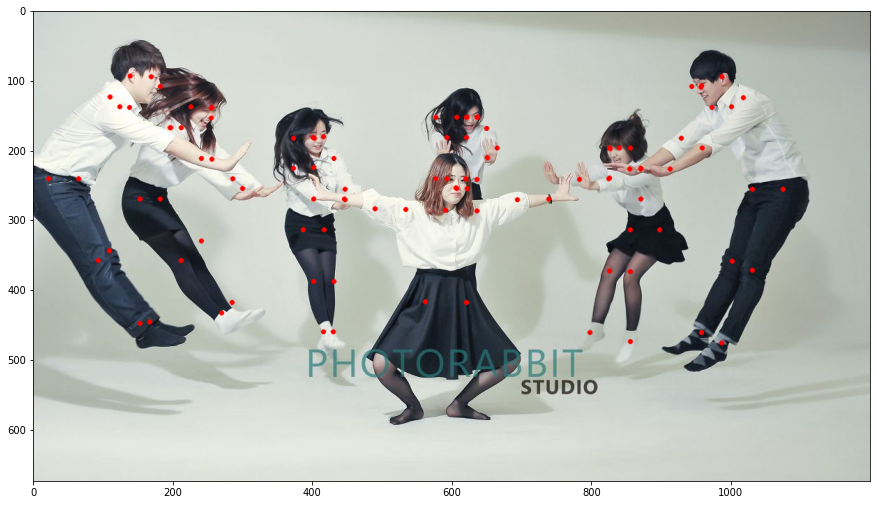

In [181]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [182]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[ 7.        , 14.        ,  0.80353653],
       [ 8.        , 15.        ,  0.68993209],
       [ 9.        , 16.        ,  0.9095412 ],
       [10.        , 17.        ,  0.70827493],
       [11.        , 18.        ,  0.70992926],
       [12.        , 19.        ,  0.80979267],
       [13.        , 20.        ,  0.52258577]]), array([[ 7.        , 30.        ,  0.67185549],
       [ 8.        , 31.        ,  0.72957924],
       [ 9.        , 32.        ,  0.79459942],
       [10.        , 33.        ,  0.62311066],
       [11.        , 34.        ,  0.64774237],
       [12.        , 36.        ,  0.68935846],
       [13.        , 35.        ,  0.5354102 ]]), array([[14.        , 21.        ,  0.82707634],
       [16.        , 22.        ,  0.90659711],
       [18.        , 25.        ,  0.84980401],
       [19.        , 23.        ,  0.79012539],
       [20.        , 25.        ,  0.79669948]]), array([[22.        , 26.        ,  0.89588562],
       [23.        , 29.        ,

In [183]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

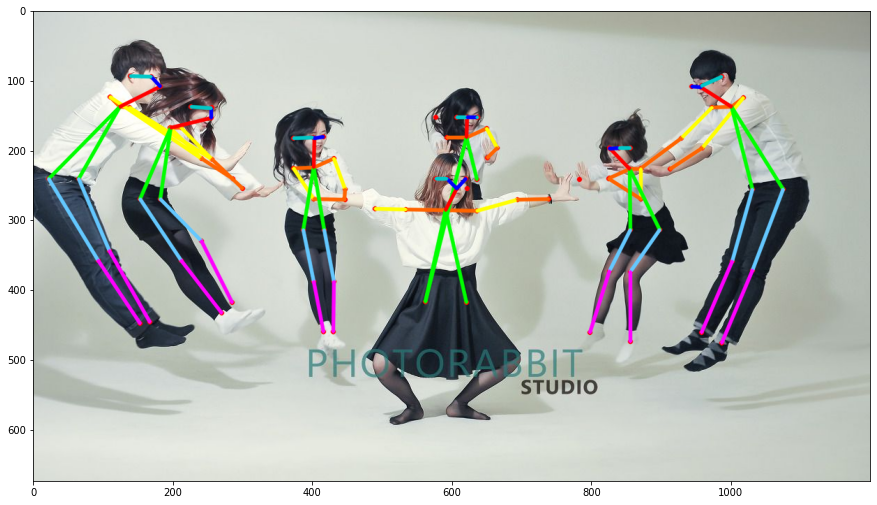

In [184]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

In [185]:
detected_keypoints

[[(607, 255, 0.89597577, 0),
  (827, 198, 0.8069985, 1),
  (403, 183, 0.8172617, 2),
  (622, 153, 0.7518757, 3),
  (255, 154, 0.840413, 4),
  (957, 110, 0.80589694, 5),
  (182, 109, 0.8395751, 6)],
 [(591, 286, 0.77133024, 7),
  (855, 227, 0.7296775, 8),
  (402, 225, 0.77148724, 9),
  (621, 182, 0.7120199, 10),
  (197, 168, 0.63609254, 11),
  (1001, 138, 0.779152, 12),
  (124, 138, 0.4815492, 13)],
 [(534, 285, 0.7603516, 14),
  (826, 240, 0.5908152, 15),
  (373, 226, 0.79069513, 16),
  (593, 182, 0.548577, 17),
  (196, 168, 0.61331004, 18),
  (973, 139, 0.7023993, 19),
  (110, 124, 0.60758036, 20)],
 [(490, 284, 0.50550395, 21),
  (402, 270, 0.7018954, 22),
  (929, 183, 0.76503617, 23),
  (577, 153, 0.11752454, 24),
  (241, 212, 0.5347624, 25)],
 [(447, 271, 0.897885, 26),
  (783, 242, 0.11059975, 27),
  (286, 241, 0.40204975, 28),
  (871, 226, 0.6625227, 29)],
 [(636, 287, 0.7274241, 30),
  (871, 227, 0.6508305, 31),
  (431, 212, 0.7405778, 32),
  (650, 169, 0.66476053, 33),
  (212, 

In [186]:
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
#         print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)

In [193]:
position = []

keylist = np.empty((len(personwiseKeypoints), 13, 2))

for i in range(1, 14):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        A = np.int32(keypoints_list[personwiseKeypoints[n][i].astype(int)])
        keylist[n][i - 1] = A[:-1]

In [204]:
keylist[0]

array([[5.910e+002, 2.860e+002],
       [5.340e+002, 2.850e+002],
       [4.274e-321, 9.931e-322],
       [9.870e+002, 9.500e+001],
       [6.360e+002, 2.870e+002],
       [6.940e+002, 2.710e+002],
       [4.244e-321, 1.008e-321],
       [4.219e-321, 1.033e-321],
       [9.870e+002, 9.500e+001],
       [4.204e-321, 1.042e-321],
       [4.204e-321, 1.047e-321],
       [9.870e+002, 9.500e+001],
       [9.870e+002, 9.500e+001]])

In [216]:
t0 = cv2.getTickCount()


last_position = position
final_position_index = -1
for n in range(len(personwiseKeypoints)):
    short_distance = 10000
    if int(keylist[n][0][0]) == 0:
        continue
    else:
        count = -1
        last_p_index = -1
        short_p_index = -1
        for last_p in range(len(last_position)):
            temp_x = keylist[n][0][0] - last_position[last_p][0]
            temp_y = keylist[n][0][1] - last_position[last_p][1]
            temp_distance = temp_x * temp_x + temp_y * temp_y
            if temp_distance < short_distance:
                short_distance = temp_distance
                last_p_index = last_p
                position_index = last_position[last_p][2]
        if last_p_index == -1:
            final_position_index+=1
            position.append([keylist[n][0][0], keylist[n][0][1], final_position_index])
        else:
            position.append([keylist[n][0][0], keylist[n][0][1], position_index])
            del last_position[last_p_index]
t1 = cv2.getTickCount()
print ("took %f seconds." % ((t1-t0)/cv2.getTickFrequency()))

took 0.000411 seconds.


In [217]:
position

[[591.0, 286.0, 0],
 [855.0, 227.0, 1],
 [402.0, 225.0, 2],
 [621.0, 182.0, 3],
 [1001.0, 138.0, 5],
 [124.0, 138.0, 4]]